In [32]:
pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 61.6 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install torch


[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import intel_extension_for_pytorch as ipex  # Import IPEX

# Replace 'path_to_file.tsv' with the actual file path
file_path = 'logd74.tsv'

# Load the dataset
df = pd.read_csv(file_path, delimiter='\t')

# Function to convert SMILES to Morgan fingerprint
def smiles_to_fp(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=n_bits)
    return np.array(fp)

# Apply fingerprint generation
df['fp'] = df['SMILES'].apply(smiles_to_fp)

# Prepare input and target data
X = np.array(list(df['fp']))
y = df['logD7.4'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize model
model = Net()

# Convert model to `bfloat16`
model = model.to(torch.bfloat16)

# Enable IPEX optimization with `bfloat16`
optimizer = optim.AdamW(model.parameters(), lr=0.001)
model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=torch.bfloat16)

# Training loop
epochs = 100
X_train_tensor = torch.tensor(X_train, dtype=torch.bfloat16)
y_train_tensor = torch.tensor(y_train, dtype=torch.bfloat16)

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train_tensor)
    
    # Convert to float32 for loss calculation
    loss = nn.MSELoss()(outputs.float().squeeze(), y_train_tensor.float())
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Evaluate on the test set
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.bfloat16)
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = mean_squared_error(y_test, test_outputs.float().numpy().squeeze())  # Convert to float for evaluation
    print(f'Test MSE: {test_loss}')


2024-11-15 18:16:06,767 - _logger.py - IPEX - WARNING - [NotSupported]Can't convert model's parameters dtype from torch.bfloat16 to torch.bfloat16
2024-11-15 18:16:06,768 - _logger.py - IPEX - WARNING - [NotSupported]Can't convert model's parameters dtype from torch.bfloat16 to torch.bfloat16
2024-11-15 18:16:06,768 - _logger.py - IPEX - WARNING - [NotSupported]Can't convert model's parameters dtype from torch.bfloat16 to torch.bfloat16
2024-11-15 18:16:06,769 - _logger.py - IPEX - WARNING - [NotSupported]Can't convert model's parameters dtype from torch.bfloat16 to torch.bfloat16
2024-11-15 18:16:06,769 - _logger.py - IPEX - WARNING - [NotSupported]Can't convert model's parameters dtype from torch.bfloat16 to torch.bfloat16
2024-11-15 18:16:06,769 - _logger.py - IPEX - WARNING - [NotSupported]Can't convert model's parameters dtype from torch.bfloat16 to torch.bfloat16


Epoch 1/100, Loss: 6.502844333648682
Epoch 2/100, Loss: 5.3733601570129395
Epoch 3/100, Loss: 4.009426593780518
Epoch 4/100, Loss: 2.748927116394043
Epoch 5/100, Loss: 2.864649772644043
Epoch 6/100, Loss: 2.7417993545532227
Epoch 7/100, Loss: 1.9427889585494995
Epoch 8/100, Loss: 1.437041163444519
Epoch 9/100, Loss: 1.3101407289505005
Epoch 10/100, Loss: 1.2616815567016602
Epoch 11/100, Loss: 1.1388328075408936
Epoch 12/100, Loss: 0.9675084948539734
Epoch 13/100, Loss: 0.8545002937316895
Epoch 14/100, Loss: 0.8781441450119019
Epoch 15/100, Loss: 0.9346999526023865
Epoch 16/100, Loss: 0.8828975558280945
Epoch 17/100, Loss: 0.7502502202987671
Epoch 18/100, Loss: 0.6457057595252991
Epoch 19/100, Loss: 0.6064599752426147
Epoch 20/100, Loss: 0.5996412634849548
Epoch 21/100, Loss: 0.579341471195221
Epoch 22/100, Loss: 0.5361649394035339
Epoch 23/100, Loss: 0.4911870062351227
Epoch 24/100, Loss: 0.47135332226753235
Epoch 25/100, Loss: 0.47864946722984314
Epoch 26/100, Loss: 0.4827081263065338

In [18]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import intel_extension_for_pytorch as ipex  # Import IPEX

# Load the dataset
file_path = 'logd74.tsv'
df = pd.read_csv(file_path, delimiter='\t')

# Function to convert SMILES to Morgan fingerprint without using deprecated methods
def smiles_to_fp(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits)
    return np.array(fp)

# Apply fingerprint generation
df['fp'] = df['SMILES'].apply(smiles_to_fp)

# Prepare input and target data
X = np.array(list(df['fp']))
y = df['logD7.4'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define an improved neural network model
class ImprovedNet(nn.Module):
    def __init__(self):
        super(ImprovedNet, self).__init__()
        self.fc1 = nn.Linear(2048, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(512, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        return self.fc3(x)

# Initialize model, loss, and optimizer
model = ImprovedNet()
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Adjusted learning rate
model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=torch.float32)  # Use float32
criterion = nn.MSELoss()

# Convert training data to tensors and apply IPEX optimization
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Training loop with mini-batches
batch_size = 64  # Set batch size
epochs = 100
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    permutation = torch.randperm(X_train_tensor.size(0))
    epoch_loss = 0

    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train_tensor[indices], y_train_tensor[indices]
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / (i + 1)}')

# Evaluate on the test set
model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = mean_squared_error(y_test, test_outputs.numpy().squeeze())
    print(f'Test MSE: {test_loss}')



[09:45:20] DEPRECATION WARNING: please use MorganGenerator
[09:45:20] DEPRECATION WARNING: please use MorganGenerator
[09:45:20] DEPRECATION WARNING: please use MorganGenerator
[09:45:20] DEPRECATION WARNING: please use MorganGenerator
[09:45:20] DEPRECATION WARNING: please use MorganGenerator
[09:45:20] DEPRECATION WARNING: please use MorganGenerator
[09:45:20] DEPRECATION WARNING: please use MorganGenerator
[09:45:20] DEPRECATION WARNING: please use MorganGenerator
[09:45:20] DEPRECATION WARNING: please use MorganGenerator
[09:45:20] DEPRECATION WARNING: please use MorganGenerator
[09:45:20] DEPRECATION WARNING: please use MorganGenerator
[09:45:20] DEPRECATION WARNING: please use MorganGenerator
[09:45:20] DEPRECATION WARNING: please use MorganGenerator
[09:45:20] DEPRECATION WARNING: please use MorganGenerator
[09:45:20] DEPRECATION WARNING: please use MorganGenerator
[09:45:20] DEPRECATION WARNING: please use MorganGenerator
[09:45:20] DEPRECATION WARNING: please use MorganGenerat

Epoch 1/100, Loss: 0.05141234278280201
Epoch 2/100, Loss: 0.013297784620835763
Epoch 3/100, Loss: 0.00991588638246126
Epoch 4/100, Loss: 0.008096940674244893
Epoch 5/100, Loss: 0.007894325216478329
Epoch 6/100, Loss: 0.00662103896688591
Epoch 7/100, Loss: 0.005379945787299038
Epoch 8/100, Loss: 0.005215496422853757
Epoch 9/100, Loss: 0.007103559431290813
Epoch 10/100, Loss: 0.006376886680107585
Epoch 11/100, Loss: 0.0070796782024196425
Epoch 12/100, Loss: 0.004320658037362157
Epoch 13/100, Loss: 0.006139818774152095
Epoch 14/100, Loss: 0.004753291773025275
Epoch 15/100, Loss: 0.004328411359053392
Epoch 16/100, Loss: 0.005482326815093773
Epoch 17/100, Loss: 0.0047449207259393986
Epoch 18/100, Loss: 0.003646701507876682
Epoch 19/100, Loss: 0.003934197717552866
Epoch 20/100, Loss: 0.0033486820217491923
Epoch 21/100, Loss: 0.003921665409071124
Epoch 22/100, Loss: 0.004036084548419668
Epoch 23/100, Loss: 0.0030694966398619756
Epoch 24/100, Loss: 0.004021728517219773
Epoch 25/100, Loss: 0.00

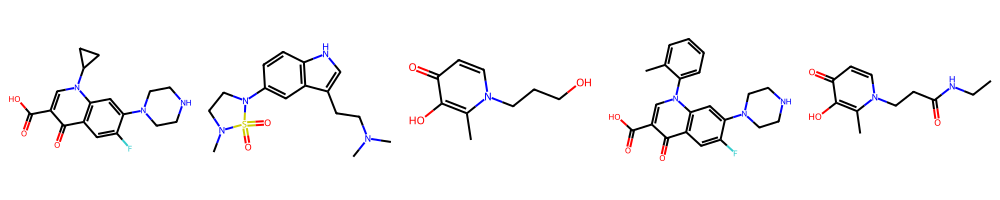

In [5]:
from rdkit.Chem import Draw

mols = [Chem.MolFromSmiles(smiles) for smiles in df['SMILES'][:5]]
img = Draw.MolsToImage(mols)
img.show()

In [9]:
import torch
from pathlib import Path
import openvino.runtime as ov
from torch import nn
from intel_extension_for_pytorch import optimize  # Import IPEX
import io

# Define your model architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2048, 1024)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(512, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

# Load the PyTorch model
model = Net()
model.load_state_dict(torch.load('lipophilicity_model.pth'))
model.eval()

# Define dummy input for export
dummy_input = torch.randn(1, 2048)

# Export the unoptimized PyTorch model to ONNX
onnx_path = "lipophilicity_model_unoptimized.onnx"
torch.onnx.export(model, dummy_input, onnx_path, opset_version=11, input_names=["input"], output_names=["output"])

# Optimize the model with IPEX for runtime
model = model.to(torch.bfloat16)
optimized_model = optimize(model, dtype=torch.bfloat16)

# Load and optimize the ONNX model in OpenVINO
core = ov.Core()
onnx_model = core.read_model(onnx_path)

# Compile the model for CPU
compiled_model = core.compile_model(onnx_model, "CPU")

# Export the OpenVINO model to IR format using BytesIO
with io.BytesIO() as model_stream:
    compiled_model.export_model(model_stream)
    model_stream.seek(0)  # Go to the beginning of the stream

    # Write the content to an XML file
    with open("lipophilicity_model.xml", "wb") as f:
        f.write(model_stream.read())

print("Model successfully converted to OpenVINO IR format and saved as 'lipophilicity_model.xml'.")






Model successfully converted to OpenVINO IR format and saved as 'lipophilicity_model.xml'.


/tmp/ipykernel_33208/1788511327.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lipophilicity_model.pth'))


In [10]:
pip install onnx

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

In [29]:
# Assuming you have a function to convert SMILES to fingerprints
def smiles_to_fp(smiles, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=n_bits)
    return np.array(fp)

# Example SMILES string
smiles = "C[C@H](N)C(=O)O"  # Replace with your SMILES string

# Prepare input tensor
fp = smiles_to_fp(smiles)
input_tensor = torch.tensor(fp, dtype=torch.float32).unsqueeze(0)  # Adding batch dimension

# Convert PyTorch tensor to NumPy array
input_numpy = input_tensor.numpy()

# Create OpenVINO tensor from NumPy array
ov_input_tensor = ov.Tensor(input_numpy)

# Run model inference
result = compiled_model([ov_input_tensor])[0]

# Postprocess and display the result
predicted_lipophilicity = result[0]  # Assuming the model outputs a single value
print(f"Predicted Lipophilicity: {predicted_lipophilicity}")


Predicted Lipophilicity: [-1.5625]


[19:57:41] DEPRECATION WARNING: please use MorganGenerator


In [30]:
pip install gradio

Note: you may need to restart the kernel to use updated packages.


In [1]:
import gradio as gr
from rdkit import Chem
from rdkit.Chem import Draw, rdMolDescriptors
import numpy as np
import torch
import openvino.runtime as ov
import intel_extension_for_pytorch as ipex  # Import IPEX

# Define the PyTorch model (Assuming `Net` is your model class)
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(2048, 1024)
        self.dropout1 = torch.nn.Dropout(0.3)
        self.fc2 = torch.nn.Linear(1024, 512)
        self.dropout2 = torch.nn.Dropout(0.3)
        self.fc3 = torch.nn.Linear(512, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)

# Load and optimize the model with IPEX
torch_model = Net()
torch_model.load_state_dict(torch.load('lipophilicity_model.pth'))
torch_model.eval()
ipex_model = ipex.optimize(torch_model)  # IPEX-optimized PyTorch model

# Set up OpenVINO model
core = ov.Core()
ov_model = core.read_model('./lipophilicity_model1.onnx')
compiled_ov_model = core.compile_model(ov_model, "CPU")

# Updated function for SMILES to fingerprint conversion using RDKit
def smiles_to_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string.")
    # Generate a Morgan fingerprint with radius 2 and 2048 bits
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    return np.array(fp, dtype=np.float32)  # Convert to NumPy array

# Prediction function with an option for IPEX or OpenVINO
def predict_and_visualize(smiles, method="IPEX"):
    # Convert SMILES to fingerprint
    try:
        fp = smiles_to_fp(smiles)
    except ValueError as e:
        return str(e), None
    
    input_tensor = torch.tensor(fp, dtype=torch.float32).unsqueeze(0)  # Shape becomes [1, 2048]

    # Run inference with the selected method
    if method == "OpenVINO":
        input_numpy = input_tensor.numpy()
        ov_input_tensor = ov.Tensor(input_numpy)
        result = compiled_ov_model([ov_input_tensor])[0]
        predicted_lipophilicity = result[0].item()
    else:  # IPEX inference
        with torch.no_grad():
            result = ipex_model(input_tensor)
        predicted_lipophilicity = result.item()

    # Visualize molecule
    mol = Chem.MolFromSmiles(smiles)
    img = Draw.MolToImage(mol)

    # Updated interpretation of the lipophilicity value
    if predicted_lipophilicity > 2.0:
        interpretation = (
            f"Lipophilicity: {predicted_lipophilicity:.4f} (High) - This molecule has high lipophilicity, "
            "indicating good membrane permeability but potential risks of bioaccumulation and poor water solubility."
        )
    elif predicted_lipophilicity < 1.0:
        interpretation = (
            f"Lipophilicity: {predicted_lipophilicity:.4f} (Low) - This molecule has low lipophilicity, "
            "suggesting poor membrane permeability, which could limit its effectiveness as a drug."
        )
    else:
        interpretation = (
            f"Lipophilicity: {predicted_lipophilicity:.4f} (Optimal) - This molecule has a balanced lipophilicity, "
            "suggesting good permeability and solubility, favorable for drug-like properties."
        )

    return interpretation, img

# Gradio interface function
def gradio_interface(smiles, method):
    interpretation, img = predict_and_visualize(smiles, method)
    return interpretation, img

# Set up Gradio UI
iface = gr.Interface(
    fn=gradio_interface,
    inputs=[
        gr.Textbox(label="SMILES String"),
        gr.Radio(["IPEX", "OpenVINO"], label="Inference Method", value="IPEX")
    ],
    outputs=[gr.Textbox(label="Interpretation"), gr.Image(label="Molecule Structure")],
    title="Lipophilicity Predictor",
    description="Enter a SMILES string to predict lipophilicity and view the molecule structure. Choose between IPEX or OpenVINO for inference."
)

# Launch Gradio app
iface.launch(share=True)





/tmp/ipykernel_33208/81865551.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch_model.load_state_dict(torch.load('lipophilicity_model.pth'))


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://91f6b6f76f614839f4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/opt/app-root/lib64/python3.9/site-packages/torch/_inductor/compile_worker/__main__.py", line 45, in <module>
    main()
  File "/opt/app-root/lib64/python3.9/site-packages/torch/_inductor/compile_worker/__main__.py", line 38, in main
    pre_fork_setup()
  File "/opt/app-root/lib64/python3.9/site-packages/torch/_inductor/async_compile.py", line 62, in pre_fork_setup
    from triton.compiler.compiler import triton_key
ImportError: cannot import name 'triton_key' from 'triton.compiler.compiler' (/opt/app-root/lib64/python3.9/site-packages/triton/compiler/compiler.py)
W1114 20:29:17.576666 140259664733760 intel_extension_for_pytorch/utils/_logger.py:72] SubprocPool unclean exit


[21:40:06] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5
[21:40:06] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[21:40:06] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[21:40:06] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5
[21:40:06] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5


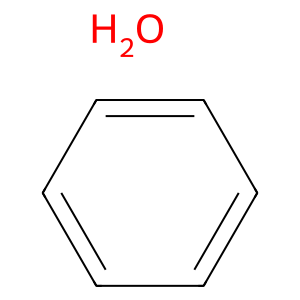

TypeError: unsupported format string passed to numpy.ndarray.__format__